## Loading and installing the necessary packages

In [ ]:
import numpy as np 
import pandas as pd 
from PIL import Image
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
from typing import List
import re
from tqdm import tqdm
import lightning as L
from torch.utils.data import DataLoader, Dataset
import torch
from torchvision.transforms import v2
from torch import nn
from glob import glob
import random
import os
import sys

### Setting up and Loading the data

In [3]:
TRAIN_DATA_PATH = 'data/train'
TEST_DATA_PATH = 'data/test'

In [4]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv("Test.csv")
submission_df = pd.read_csv("Sample_Submission.csv")

In [5]:
train_df.head()

ID  FolderName  PlantNumber Side  Start  End  RootVolume  \
0  ID_826322_Lbmaya  A6dzrkjqvl            3    L     33   42         0.9   
1  ID_718181_Bslpwx  Ypktwvqjbn            7    L     33   41         1.5   
2  ID_465762_L1n61d  Ox18ob0syv            4    R     21   28         2.7   
3  ID_626872_Pbmx2e  Hqcekwpxgu            2    R     30   39         2.6   
4  ID_518846_Opko8c  Ummqfuetoc            1    R     17   26         2.7   

             Genotype  Stage  
0  IITA-TMS-IBA000070  Early  
1           IBA154810  Early  
2           IBA980581  Early  
3  IITA-TMS-IBA000070  Early  
4           IBA980581  Early

In [6]:
test_df.head()

ID  FolderName  PlantNumber Side  Start  End  \
0  ID_208667_Hnkl8q  L5l1h3kekg            7    L     38   50   
1  ID_285249_Jnjvav  Wgutyon8uu            6    R     23   37   
2  ID_697947_Yec6bd  Mylwjeq6tq            3    R     19   42   
3  ID_534638_X3j91f  Pfp24vx905            2    R     27   34   
4  ID_929298_Xvymuz  Mrw7chmalv            4    R     30   43   

             Genotype  Stage  
0  IITA-TMS-IBA000070  Early  
1             TMEB419  Early  
2           IBA980581  Early  
3             TMEB419  Early  
4           IBA154810  Early

In [7]:
test_df.shape, train_df.shape, submission_df.shape

((130, 8), (386, 9), (130, 2))

In [8]:
test_df['Stage'].value_counts()

Stage
Early    125
Late       5
Name: count, dtype: int64

In [9]:
train_df['FolderName'].unique().size, test_df['FolderName'].unique().size

(98, 62)

### Loading the segmantation models

In [10]:
# Since the organizers didn't provide performance metrics, we will be using all the models (For Now)
segmentation_models = {
    "full" : YOLO("Models/Models/best_full.pt"),
    "early" : YOLO("Models/Models/best_early.pt"),
    "late" : YOLO("Models/Models/best_late.pt")
}

In [11]:
sample = "data/train/A2miww5mfx/A2miww5mfx_L_014.png"

seg_model = segmentation_models['full']
results = seg_model(sample)


image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\train\A2miww5mfx\A2miww5mfx_L_014.png: 32x640 4 roots, 819.6ms
Speed: 94.3ms preprocess, 819.6ms inference, 179.5ms postprocess per image at shape (1, 3, 32, 640)


## Visualizing the images

In [12]:
PATH = 'C:/Users/Reinhard/Documents/computer_vision_projects/root_volume_estimation_challenge'

In [13]:
imgs = glob(f'{PATH}/data/train/*/*')
Image.open(imgs[0])

Since the images arent clear we define helper fuctions that will help us visualize them

### Defining helper functions for visualizing the images

In [14]:
def get_images_labels(path, folder_name):
    labels = glob(f'{path}/train_labels/train_labels/{folder_name}*')
    labels = sorted(labels)
    imgs = glob(f'{path}/data/train/{folder_name.split("_")[0]}/{folder_name}*')
    imgs = sorted(imgs)
    return labels, imgs

def generate_random_color():
    """Generate a bright, random color."""
    return tuple(random.randint(100, 255) for _ in range(3))  # RGB values

def parse_label_file(label_path, img_width, img_height):
    """Parse label file and extract polygon coordinates, converting from normalized to pixel values."""
    polygons = []
    with open(label_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            if len(values) < 3:  # Skip empty or incorrect lines
                continue
            coords = [float(v) for v in values[1:]]  # Ignore the class_id
            polygon = np.array([(int(x * img_width), int(y * img_height)) for x, y in zip(coords[0::2], coords[1::2])], dtype=np.int32)
            polygons.append(polygon)
    return polygons


In [15]:
def draw_masks(image_path, label_path):
    """Draws polygon masks with unique colors per instance on the image."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    img_height, img_width, _ = image.shape
    polygons = parse_label_file(label_path, img_width, img_height)
    
    for polygon in polygons:
        color = generate_random_color()  # Unique color for each instance
        cv2.polylines(image, [polygon], isClosed=True, color=color, thickness=2)
        #cv2.fillPoly(image, [polygon], color=color + (50,))  # Transparent fill
    
    return image

def resize_image(image, width):
    """Resize image while maintaining aspect ratio."""
    h, w, _ = image.shape
    print(h,w)
    scale = width / w
    new_h = int(h * scale)
    resized_image = cv2.resize(image, (width, new_h), interpolation=cv2.INTER_AREA)
    return resized_image

In [16]:
def process_and_display(label_files, image_files):
    """Find matching files, draw masks, resize images, stack vertically, and display."""
    matching_images = []
    
    # Create a mapping for fast lookup
    label_map = {os.path.splitext(os.path.basename(lf))[0]: lf for lf in label_files}
    img_names = []
    min_width = float('inf')
    
    for image_path in image_files:
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        if image_name in label_map:
            img_names.append(image_name)
            processed_image = draw_masks(image_path, label_map[image_name])
            min_width = min(min_width, processed_image.shape[1])
            matching_images.append(processed_image)
    
    if not matching_images:
        #print("No matching images found.")
        return None, None
    
    # Ensure images have the same width by truncating from the right
    matching_images = [img[:, :min_width, :] for img in matching_images]
    
    # Stack images vertically
    final_image = np.vstack(matching_images)
    
    # Display
    plt.figure(figsize=(10, len(matching_images) * 3))
    plt.imshow(final_image)
    plt.axis('off')
    plt.show()
    
    return final_image, img_names

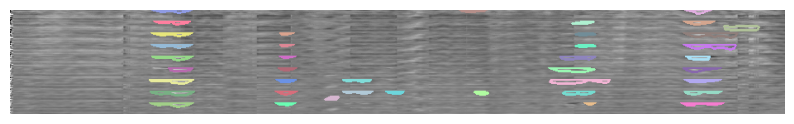

Kjvcz6bjfj_L_ ['024', '026', '027', '028', '029', '031', '033', '034', '036']


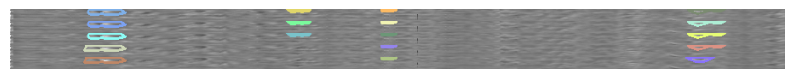

Kjvcz6bjfj_R_ ['034', '035', '036', '037', '038']


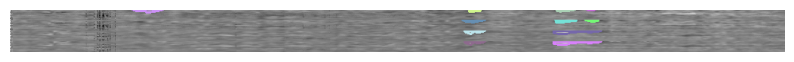

Ntqusw7xpb_L_ ['024', '026', '030', '031']


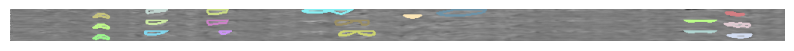

Ntqusw7xpb_R_ ['038', '039', '042']


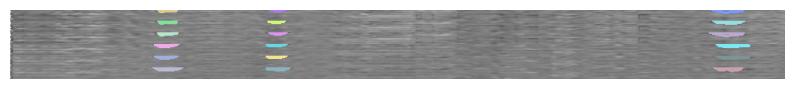

Ph2ti2sjzu_L_ ['027', '028', '029', '032', '034', '035']


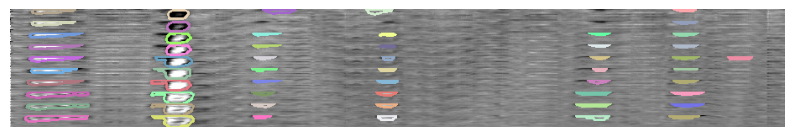

Idiolerx47_L_ ['010', '011', '013', '014', '015', '016', '017', '019', '020', '021']


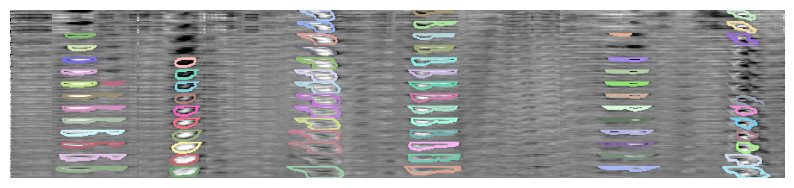

Idiolerx47_R_ ['008', '009', '011', '012', '013', '014', '015', '016', '017', '018', '019', '021', '023', '024']


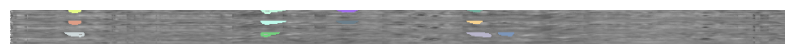

Pw4ytibfql_L_ ['026', '027', '030']


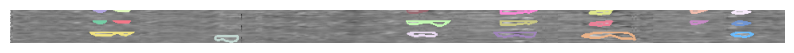

Pw4ytibfql_R_ ['030', '031', '035']


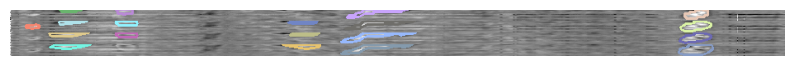

Gernxgxbnu_L_ ['014', '016', '018', '019']


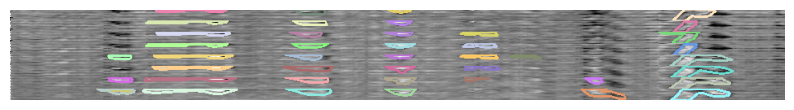

Gernxgxbnu_R_ ['012', '013', '014', '015', '016', '017', '019', '020']


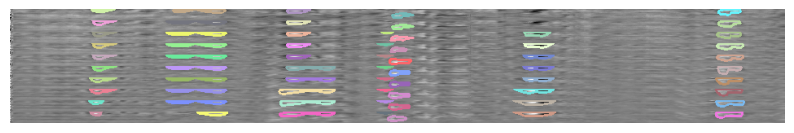

Xrrcqvdbkw_R_ ['027', '028', '029', '030', '031', '032', '033', '034', '035', '036']


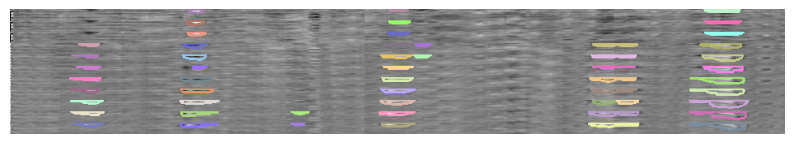

Zplb9xaxis_L_ ['010', '011', '012', '019', '020', '021', '022', '023', '024', '025', '026']


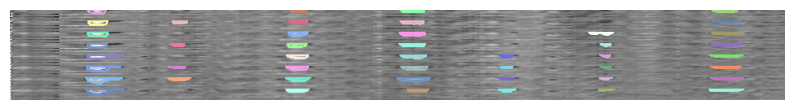

Zplb9xaxis_R_ ['014', '015', '016', '017', '018', '019', '020', '021']


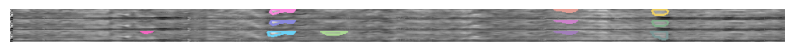

Xdi1ipcemf_L_ ['023', '024', '025']


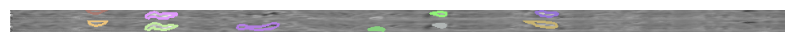

Xdi1ipcemf_R_ ['036', '037']


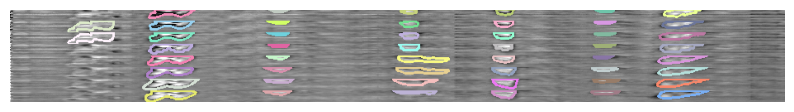

F3odypnsyf_L_ ['015', '016', '017', '018', '020', '021', '022', '023']


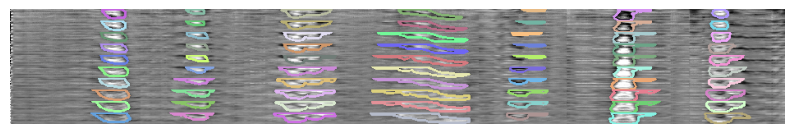

F3odypnsyf_R_ ['010', '011', '012', '013', '014', '015', '016', '018', '019', '020']


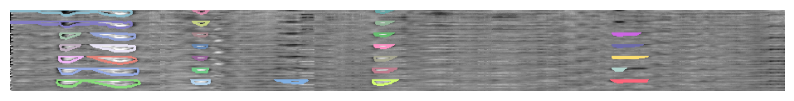

Isdzz86frg_L_ ['010', '011', '012', '013', '014', '016', '017']


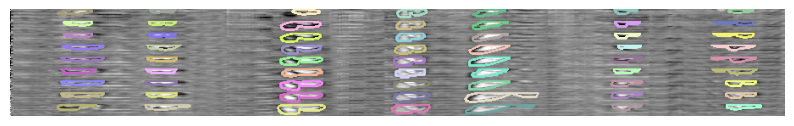

Isdzz86frg_R_ ['010', '011', '012', '013', '014', '015', '016', '017', '018']


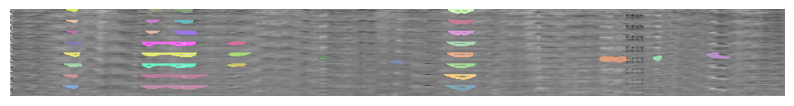

Tbhppxjkvr_L_ ['024', '025', '026', '027', '028', '029', '030', '031']


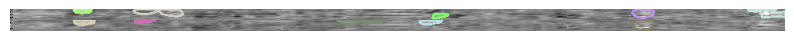

Tbhppxjkvr_R_ ['018', '021']


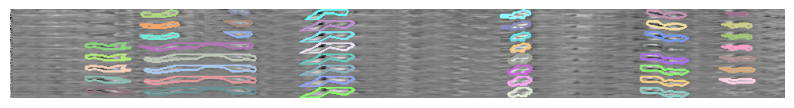

Miny0c252a_R_ ['028', '029', '030', '031', '032', '033', '034', '035']


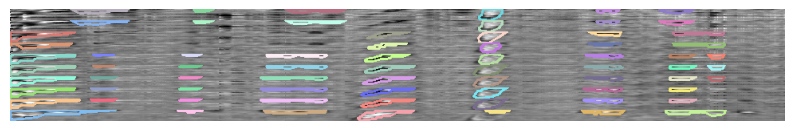

Aevcaxguiw_L_ ['008', '009', '010', '011', '012', '013', '014', '015', '016', '022']


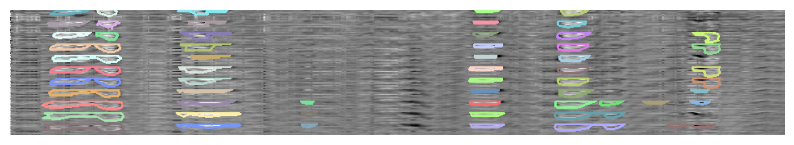

Aevcaxguiw_R_ ['010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020']


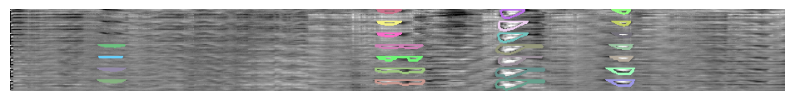

Td901zykbu_L_ ['008', '009', '010', '011', '012', '013', '014']


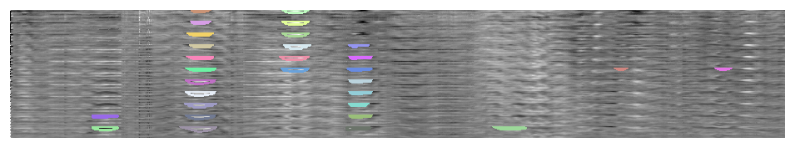

Td901zykbu_R_ ['010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020']


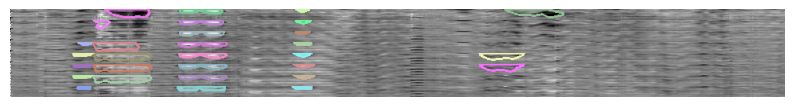

Ynjc34lyjb_L_ ['010', '011', '012', '013', '014', '015', '016', '017']


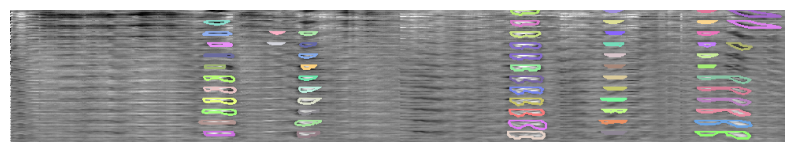

Ynjc34lyjb_R_ ['008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019']


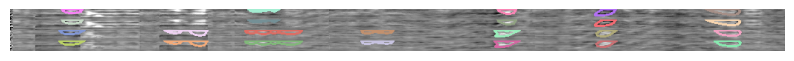

Efaiye0hmy_R_ ['021', '022', '025', '026']


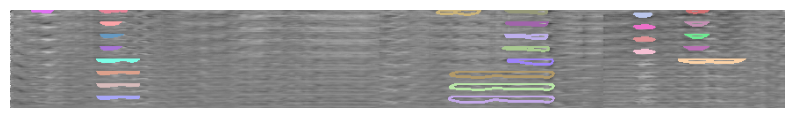

M4stkh3qez_R_ ['026', '027', '028', '029', '031', '032', '033', '034']


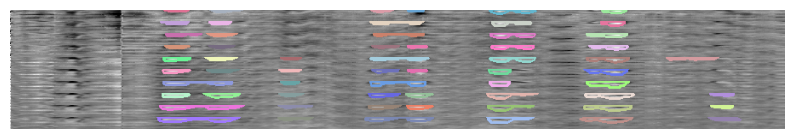

J0zdanvgrq_L_ ['010', '011', '012', '013', '015', '016', '017', '018', '019', '020']


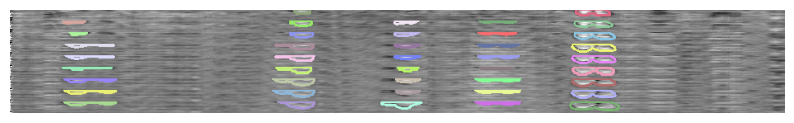

J0zdanvgrq_R_ ['010', '011', '013', '014', '015', '016', '017', '018', '019']


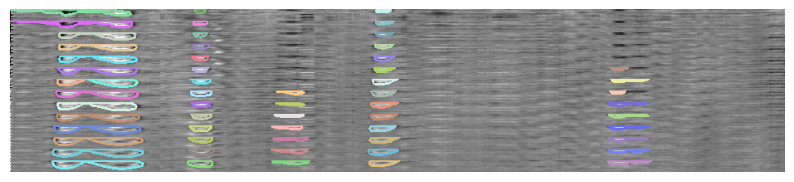

A2miww5mfx_L_ ['010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023']


A2miww5mfx_R_ ['013']


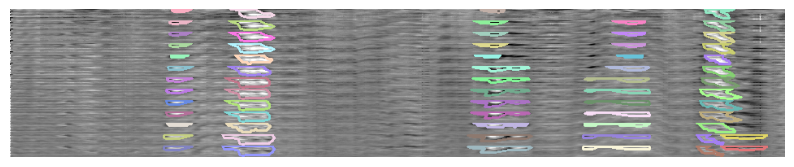

Gawaekzxou_L_ ['010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022']


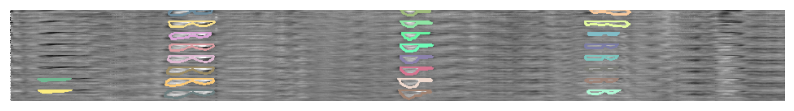

Gawaekzxou_R_ ['010', '011', '012', '013', '014', '015', '016', '017']


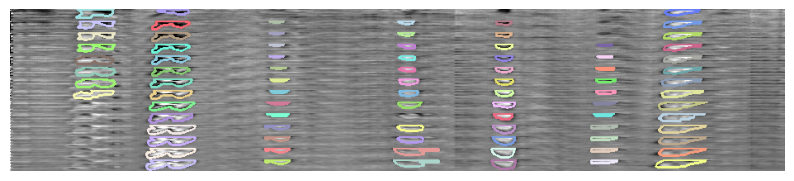

Cvdxhjziab_L_ ['010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023']


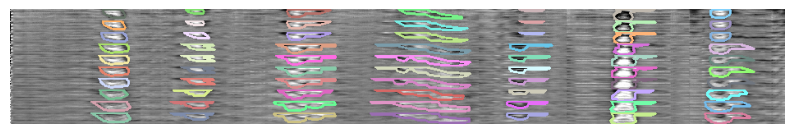

Cvdxhjziab_R_ ['010', '011', '012', '013', '014', '015', '016', '017', '018', '019']


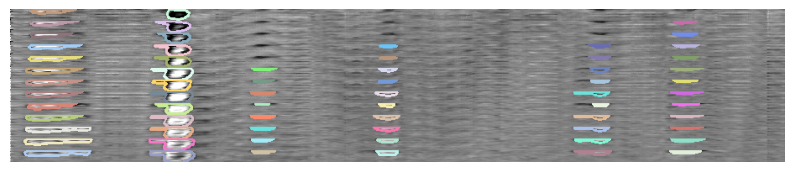

Nto14cbfiw_L_ ['010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '023']


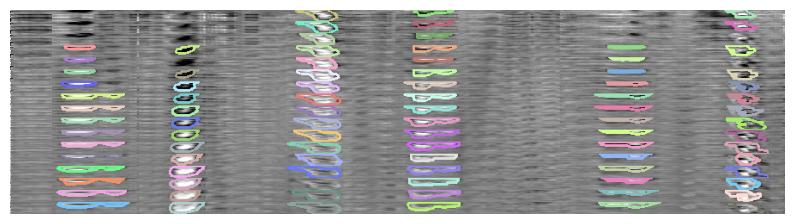

Nto14cbfiw_R_ ['008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024']


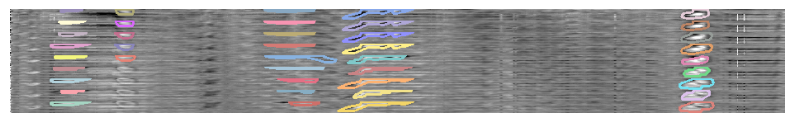

Iuxzotmvrc_L_ ['010', '011', '012', '013', '014', '015', '016', '017', '018']


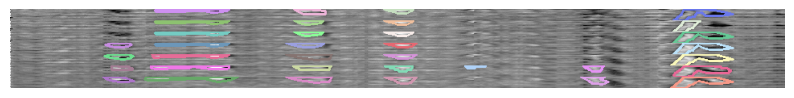

Iuxzotmvrc_R_ ['013', '014', '015', '016', '017', '018', '019']


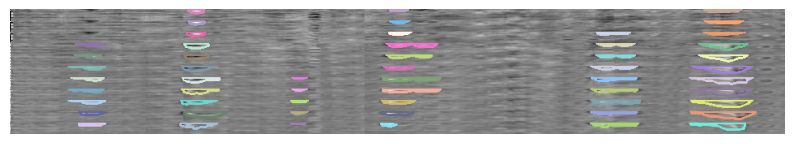

Jct834ckgh_L_ ['010', '011', '012', '019', '020', '022', '023', '024', '025', '026', '027']


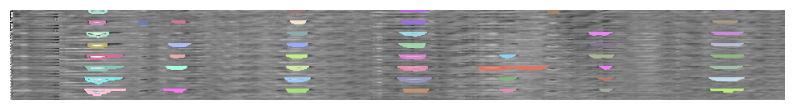

Jct834ckgh_R_ ['012', '013', '015', '016', '017', '018', '019', '020']


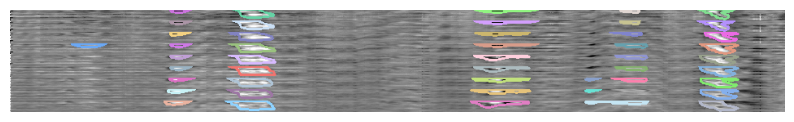

Ehwtko5bvb_L_ ['010', '011', '012', '013', '015', '016', '017', '018', '019']


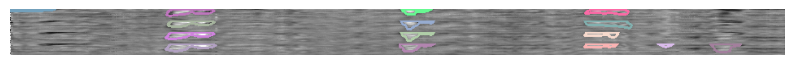

Ehwtko5bvb_R_ ['010', '011', '013', '014']


In [17]:
num_groups = 0
num_imgs = 0
for f in train_df.FolderName.unique():
    for side in ['L','R']:
        labels, imgs = get_images_labels(PATH, f'{f}_{side}_')
        img, names = process_and_display(labels, imgs)
        if img is not None:
            print(f'{f}_{side}_', [i.split('_')[-1] for i in names])
            num_groups+=1
            num_imgs += len(names)
            img_names = names


### Assesing the bounding boxes

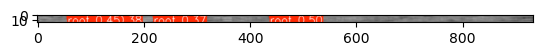

In [18]:
img = results[0].plot()
plt.imshow(img)

In [19]:
for result in results:
    for box in result.boxes.xywh:
        x, y, w, h = box  # x, y are center coordinates
        print(f"Bounding Box - X: {x}, Y: {y}, Width: {w}, Height: {h}")

Bounding Box - X: 451.03765869140625, Y: 3.013875961303711, Width: 25.670867919921875, Height: 6.027751922607422
Bounding Box - X: 104.74575805664062, Y: 4.812622547149658, Width: 93.61978912353516, Height: 9.625245094299316
Bounding Box - X: 124.95436096191406, Y: 4.5839385986328125, Width: 52.850868225097656, Height: 9.167877197265625
Bounding Box - X: 229.66575622558594, Y: 2.718564987182617, Width: 20.830291748046875, Height: 5.437129974365234


We define the function that extracts and merges segments from an image and returns only images with detetction(s). function to process a set of images and extracts the regions of interest (i.e., root segments) using a pre-trained segmentation models. It then returns the segmented images where roots are detected, or all images if no detections are made.

In [21]:

def get_segmented_images(image_paths, display_image=False):
    """Extracts and merges segments from images, returning only images with detections."""

    for model in segmentation_models.keys():
        model = segmentation_models[model]
        results = model(image_paths, verbose=False)

        if len(results[0].boxes.xyxy) != 0:
            break

    if len(results[0].boxes.xyxy) == 0:
        # Incase of no detections, return all the images (Still thinking of better ways to overcome this)
        return [Image.open(img) for img in image_paths]
        
    segmented_images = []
    
    for img_path, result in zip(image_paths, results):
        original_image = Image.open(img_path)
        merged_image = Image.new("RGBA", original_image.size, (0, 0, 0, 0))
        
        # Skip if no detections
        if len(result.boxes.xyxy) == 0:
            continue 
            
        # Extract and paste segments
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box.tolist())
            segment = original_image.crop((x1, y1, x2, y2))
            merged_image.paste(segment, (x1, y1))
            
        segmented_images.append(merged_image)

    # Display Images
    if display_image and segmented_images:
        fig, axes = plt.subplots(1, len(segmented_images), figsize=(15, 10))
        if len(segmented_images) == 1:
            axes = [axes]
        for ax, img in zip(axes, segmented_images):
            ax.imshow(img)
            ax.axis("off")
        plt.show()

    return segmented_images

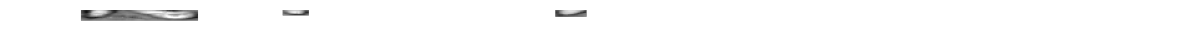

[<PIL.Image.Image image mode=RGBA size=934x14>]

In [22]:
get_segmented_images([sample], display_image = True)


Next we define a fucntion that retrieves images from a specified folder based on the scan side (left or right) and a layer range (from a starting layer to an ending layer)

In [23]:
def get_images_within_range(base_path: Path, folder: str, side: str, start: int, end: int) -> list[Path]:
    """
    Get images from a folder that match the specified side (L/R) and layer range.
    
    Args:
        base_path: Root directory containing all folders
        folder: Name of the target folder (e.g., 'Ypktwvqjbn')
        side: Scan side to filter ('L' or 'R')
        start: Starting layer (inclusive)
        end: Ending layer (inclusive)
    """
    folder_path = base_path / folder
    
    # Get all files in the folder
    try:
        images = os.listdir(folder_path)
    except FileNotFoundError:
        return []

    # Regex pattern to extract side and layer from filenames
    pattern = re.compile(r'_([LR])_(\d{3})\.png$')
    
    selected_images = []
    
    for img_name in images:
        match = pattern.search(img_name)
        if match:
            # Extract side and layer from filename
            img_side = match.group(1)
            layer = int(match.group(2))
            
            # Check if matches criteria
            if img_side == side and start <= layer <= end:
                selected_images.append(folder_path / img_name)
    
    return selected_images

In [25]:
sample_images = get_images_within_range(Path(TRAIN_DATA_PATH), "Ypktwvqjbn", "L", 33, 41)
sample_images

[WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_033.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_034.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_035.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_036.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_037.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_038.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_039.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_040.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_041.png')]

In [26]:
get_segmented_images(sample_images, display_image = True)

[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>]

We finally create a function to merge alll the image segments into one.

In [27]:
def merge_segmented_images(path: Path, folder: str, side: str, start: int, end: int):
    images_in_range = get_images_within_range(path, folder, side, start, end)
    segmented_images = get_segmented_images(images_in_range)

    # Determine final dimensions for the merged image
    total_width = sum(img.width for img in segmented_images)  # Sum of all widths
    max_height = max(img.height for img in segmented_images)  # Max height among all images

    # Create a blank canvas with a transparent background
    merged_image = Image.new("RGBA", (total_width, max_height), (0, 0, 0, 0))

    # Paste each segmented image next to the previous one (left to right)
    x_offset = 0
    for img in segmented_images:
        merged_image.paste(img, (x_offset, 0), img)  # Paste at correct position
        x_offset += img.width  # Move x-offset to the right for the next image

    return merged_image

In [29]:
merged_image = merge_segmented_images(Path(TRAIN_DATA_PATH), "Ox18ob0syv", "R", 21, 28)
merged_image

## Generating the new dataset

In [33]:
OUTPUT_IMAGE_DIR = Path("C:/Users/Reinhard/Documents/computer_vision_projects/root_volume_estimation_challenge/merged_images/")
os.makedirs(OUTPUT_IMAGE_DIR, exist_ok = True)

TRAIN_OUTPUT_DIR = OUTPUT_IMAGE_DIR / "Train"
TEST_OUTPUT_DIR = OUTPUT_IMAGE_DIR / "Test"

os.makedirs(TRAIN_OUTPUT_DIR, exist_ok = True)
os.makedirs(TEST_OUTPUT_DIR, exist_ok = True)

In [34]:
# Iterate through all the  images in the df
def generate_merged_images(df: pd.DataFrame, output_path: Path, input_path: Path):
    gen_image_paths = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Merging Images"):
        gen_image = merge_segmented_images(
            path=input_path,
            folder=row["FolderName"],
            side=row["Side"],
            start=row["Start"],
            end=row["End"]
        )
        img_path = output_path / f"{row['ID']}.png"
        gen_image.save(img_path)
        gen_image_paths.append(img_path)

    df['image segments'] = gen_image_paths
    return df

In [36]:
new_train_df = generate_merged_images(train_df, TRAIN_OUTPUT_DIR, Path(TRAIN_DATA_PATH))

Merging Images: 100%|██████████| 386/386 [41:14<00:00,  6.41s/it] 


In [37]:
new_train_df.head()

ID  FolderName  PlantNumber Side  Start  End  RootVolume  \
0  ID_826322_Lbmaya  A6dzrkjqvl            3    L     33   42         0.9   
1  ID_718181_Bslpwx  Ypktwvqjbn            7    L     33   41         1.5   
2  ID_465762_L1n61d  Ox18ob0syv            4    R     21   28         2.7   
3  ID_626872_Pbmx2e  Hqcekwpxgu            2    R     30   39         2.6   
4  ID_518846_Opko8c  Ummqfuetoc            1    R     17   26         2.7   

             Genotype  Stage  \
0  IITA-TMS-IBA000070  Early   
1           IBA154810  Early   
2           IBA980581  Early   
3  IITA-TMS-IBA000070  Early   
4           IBA980581  Early   

                                      image segments  
0  C:\Users\Reinhard\Documents\computer_vision_pr...  
1  C:\Users\Reinhard\Documents\computer_vision_pr...  
2  C:\Users\Reinhard\Documents\computer_vision_pr...  
3  C:\Users\Reinhard\Documents\computer_vision_pr...  
4  C:\Users\Reinhard\Documents\computer_vision_pr...

In [38]:
new_train_df['RootVolume'] = new_train_df.groupby('FolderName')['RootVolume'].transform('mean')

In [40]:
new_test_df = generate_merged_images(test_df, TEST_OUTPUT_DIR, Path(TEST_DATA_PATH))

Merging Images: 100%|██████████| 130/130 [15:25<00:00,  7.12s/it]


## Model training

In [41]:
train_transform = v2.Compose([
    v2.Resize(size=(20, 150), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.5], std=[0.5])
])

# Testing Transform
test_transform = v2.Compose([
    v2.Resize(size=(20, 150), antialias=True),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.5], std=[0.5])
])



In [42]:
sample_image = Image.open(sample)
sample_image

In [43]:
img = train_transform(sample_image)
img.shape

torch.Size([4, 20, 150])

We create a class to define our dataset

In [44]:
class RootVolumeDataset(Dataset):
    def __init__(self, df : pd.DataFrame, transform = None, is_train = True):
        super().__init__()
        self.df = df
        self.transform = transform
        self.is_train = is_train

    def __getitem__(self, index):
        image = Image.open(self.df['image segments'].iloc[index]).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_train:
            label = self.df['RootVolume'].iloc[index]

            return image, torch.tensor(label, dtype=torch.float32)

        return image

    def __len__(self):
        return len(self.df)

In [45]:
def seed_everything(seed):
    torch.manual_seed(seed) 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
    L.pytorch.seed_everything(seed, workers=True)
    
seed_everything(42)

Seed set to 42


In [46]:
train_dataset = RootVolumeDataset(new_train_df, train_transform)
test_dataset = RootVolumeDataset(new_test_df, test_transform, is_train = False)

In [47]:
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([3, 20, 150]), tensor(0.9333))

In [48]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

we now create a cnn model to make predictions

In [49]:
# simple CNN for the predictions
class RootVolumeRegressor(L.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Fully Connected Regression Head
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Regression output
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze()
        loss = self.criterion(preds, targets)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze()
        loss = self.criterion(preds, targets)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

model = RootVolumeRegressor()
model

RootVolumeRegressor(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

### Training our model using torch lightning

In [50]:
# 
trainer = L.Trainer(max_epochs = 20)
trainer.fit(model, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Reinhard\anaconda3\envs\deeplearning\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\Reinhard\anaconda3\envs\deeplearning\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.6 K | 

Epoch 19: 100%|██████████| 25/25 [00:04<00:00,  5.41it/s, v_num=28, train_loss=1.460] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 25/25 [00:04<00:00,  5.38it/s, v_num=28, train_loss=1.460]


### Making predictions using our trained model

In [51]:
def get_model_preds(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    preds, targets = [], []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Predict
            preds.extend(outputs.cpu().numpy().flatten())
            targets.extend(labels.cpu().numpy().flatten())

    return np.array(preds), np.array(targets)

train_preds, target = get_model_preds(model, train_dataloader)

In [52]:
def calculate_rmse(preds, targets):
    """
    Compute Root Mean Squared Error (RMSE) between predictions and ground truth targets.
    """
    preds = np.array(preds) if not isinstance(preds, np.ndarray) else preds
    targets = np.array(targets) if not isinstance(targets, np.ndarray) else targets
    
    return np.sqrt(np.mean((preds - targets) ** 2))

calculate_rmse(train_preds, target)

1.0996052

In [53]:
def get_test_preds(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    preds = []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            images = batch if isinstance(batch, torch.Tensor) else batch[0]
            images = images.to(device)

            outputs = model(images)
            preds.extend(outputs.cpu().numpy().flatten()) 

    return np.array(preds)

test_preds = get_test_preds(model, test_dataloader)

## Creating the submission file

In [54]:
test_df['RootVolume'] = test_preds
test_df.head()

ID  FolderName  PlantNumber Side  Start  End  \
0  ID_208667_Hnkl8q  L5l1h3kekg            7    L     38   50   
1  ID_285249_Jnjvav  Wgutyon8uu            6    R     23   37   
2  ID_697947_Yec6bd  Mylwjeq6tq            3    R     19   42   
3  ID_534638_X3j91f  Pfp24vx905            2    R     27   34   
4  ID_929298_Xvymuz  Mrw7chmalv            4    R     30   43   

             Genotype  Stage  \
0  IITA-TMS-IBA000070  Early   
1             TMEB419  Early   
2           IBA980581  Early   
3             TMEB419  Early   
4           IBA154810  Early   

                                      image segments  RootVolume  
0  C:\Users\Reinhard\Documents\computer_vision_pr...    2.249576  
1  C:\Users\Reinhard\Documents\computer_vision_pr...    1.989704  
2  C:\Users\Reinhard\Documents\computer_vision_pr...    1.940033  
3  C:\Users\Reinhard\Documents\computer_vision_pr...    2.016273  
4  C:\Users\Reinhard\Documents\computer_vision_pr...    1.935181

In [55]:
submission = test_df[['ID', 'RootVolume']]
submission.to_csv("final_submission.csv", index = False)
submission.head()

ID  RootVolume
0  ID_208667_Hnkl8q    2.249576
1  ID_285249_Jnjvav    1.989704
2  ID_697947_Yec6bd    1.940033
3  ID_534638_X3j91f    2.016273
4  ID_929298_Xvymuz    1.935181